In [32]:
import cot_reports as cot
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
cot_report_filter_date = pd.to_datetime('2020-01-01')

begin_year = 2025
end_year = 2025

df_com = pd.DataFrame()
for i in range(begin_year, end_year + 1):
    single_year_com = pd.DataFrame(cot.cot_year(i, cot_report_type='disaggregated_fut')) 
    df_com = pd.concat([df_com, single_year_com], ignore_index=True)

df_fin = pd.DataFrame()
for i in range(begin_year, end_year + 1):
    single_year_fin = pd.DataFrame(cot.cot_year(i, cot_report_type='traders_in_financial_futures_fut')) 
    df_fin = pd.concat([df_fin, single_year_fin], ignore_index=True)

df_com.columns = df_com.columns.str.replace('-', '_')
df_fin.columns = df_fin.columns.str.replace('-', '_')

df_com['Report_Date_as_YYYY_MM_DD'] = pd.to_datetime(df_com['Report_Date_as_YYYY_MM_DD'])
df_fin['Report_Date_as_YYYY_MM_DD'] = pd.to_datetime(df_fin['Report_Date_as_YYYY_MM_DD'])

latest_date = df_com['Report_Date_as_YYYY_MM_DD'].max()
df_com = df_com[df_com['Report_Date_as_YYYY_MM_DD'] == latest_date]
df_fin = df_fin[df_fin['Report_Date_as_YYYY_MM_DD'] == latest_date]

ref_df = pd.read_csv('../data/cot_ref_codes.csv')
ref_df = ref_df[ref_df['Include'] == 'Y']
ref_df.drop_duplicates(inplace=True)

#ref_df


Selected: disaggregated_fut
Downloaded single year data from: 2025
Stored the file f_year.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2025
Stored the file FinFutYY.txt in the working directory.


In [34]:
df_com = df_com[df_com['CFTC_Commodity_Code'].isin(ref_df['CFTC_Commodity_Code'])]
df_com = pd.merge(df_com, ref_df, how='inner', on=['CFTC_Commodity_Code', 'Market_and_Exchange_Names'])

df_fin = df_fin[df_fin['CFTC_Commodity_Code'].isin(df_fin['CFTC_Commodity_Code'])]
df_fin = pd.merge(df_fin, ref_df, how='inner', on=['CFTC_Commodity_Code', 'Market_and_Exchange_Names'])

#df_com

In [35]:
df_fin['Dealer_Positions_Long_All_Percent'] = (df_fin['Dealer_Positions_Long_All'] / (df_fin['Dealer_Positions_Long_All'] + df_fin['Dealer_Positions_Short_All'])) * 100
df_fin['Dealer_Positions_Short_All_Percent'] = (df_fin['Dealer_Positions_Short_All'] / (df_fin['Dealer_Positions_Long_All'] + df_fin['Dealer_Positions_Short_All'])) * 100

df_com['Commercial_Positions_Long_All'] = df_com['Prod_Merc_Positions_Long_All'] + df_com['Swap_Positions_Long_All'] + df_com['Swap__Positions_Spread_All']
df_com['Commercial_Positions_Short_All'] = df_com['Prod_Merc_Positions_Short_All'] + df_com['Swap__Positions_Short_All'] + df_com['Swap__Positions_Spread_All']
df_com['Dealer_Positions_Long_All_Percent'] = (df_com['Commercial_Positions_Long_All'] / (df_com['Commercial_Positions_Long_All'] + df_com['Commercial_Positions_Short_All'])) * 100
df_com['Dealer_Positions_Short_All_Percent'] = (df_com['Commercial_Positions_Short_All'] / (df_com['Commercial_Positions_Long_All'] + df_com['Commercial_Positions_Short_All'])) * 100


df_com = df_com[['Short_Code', 'Dealer_Positions_Long_All_Percent', 'Dealer_Positions_Short_All_Percent']]
df_com.drop_duplicates(inplace=True)

df_fin = df_fin[['Short_Code', 'Dealer_Positions_Long_All_Percent', 'Dealer_Positions_Short_All_Percent']]
df_fin.drop_duplicates(inplace=True)

df = pd.concat([df_com, df_fin])
#df

Chart saved as ../charts/chart_2025-03-17.png


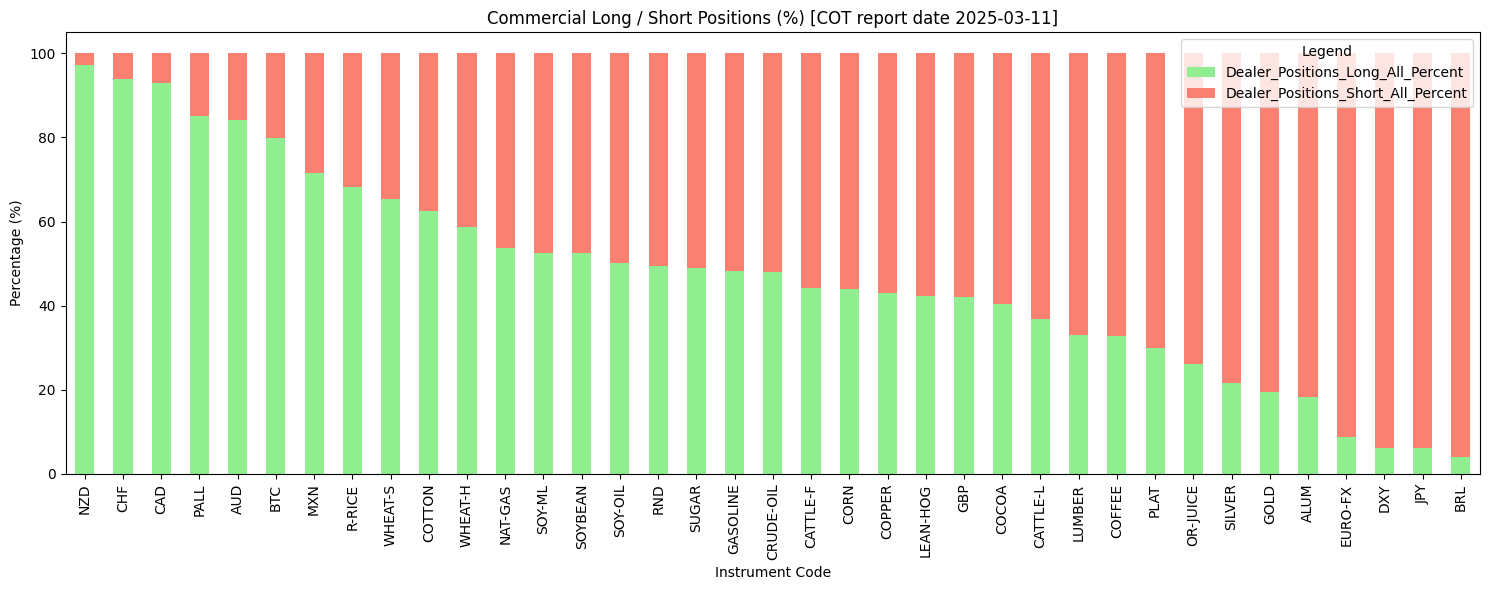

In [36]:
df = df.sort_values(by='Dealer_Positions_Short_All_Percent')

# Plot the stacked bar chart
ax = df.set_index('Short_Code').plot(
    kind='bar', stacked=True, figsize=(15, 6), 
    color=['lightgreen', 'salmon']
)

# Add labels and title
plt.xlabel('Instrument Code')
plt.ylabel('Percentage (%)')
plt.title('Commercial Long / Short Positions (%) [COT report date '+latest_date.strftime('%Y-%m-%d')+']')
plt.legend(title='Legend', loc='upper right')

# Show the chart
plt.tight_layout()

# Get the current date in YYYY-MM-DD format
current_date = datetime.now().strftime("%Y-%m-%d")
# Save the figure with the date in the filename
filename = f"../charts/chart_{current_date}.png"
plt.savefig(filename)

print(f"Chart saved as {filename}")

plt.show()